In [9]:
import eikon as ek
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import dateutil.relativedelta

ek.set_app_key('89915a3b58874e1599870c6ecc45d6edd6344f8c')

In [10]:
lists_df = pd.read_csv('../data/constituents_lists.csv')
jl_list = lists_df.JL_List.tolist()[:-3]
download_list = lists_df.Data_Download_List.tolist()

In [11]:
len(jl_list)

1580

In [12]:
pcf_returned,err = ek.get_data(instruments=jl_list,fields=['TR.PriceToCFPerShare','TR.PriceToCFPerShare.date','TR.PriceToCFPerShare.periodenddate'],parameters={'SDate':'20000101','EDate':'20230101','Frq':'CM'})

In [14]:
pcf_returned.isna().sum()

None                                     0
TR.PRICETOCFPERSHARE                  1580
TR.PRICETOCFPERSHARE.DATE             1580
TR.PRICETOCFPERSHARE.periodenddate    1580
dtype: int64

In [ ]:
pcf_returned_2,err = ek.get_data(instruments=jl_list,fields=['TR.PriceToCFPerShare','TR.PriceToCFPerShare.date','TR.PriceToCFPerShare.periodenddate'],parameters={'SDate':'20000101','EDate':'20230101','Frq':'CM'})

In [ ]:
pcf_returned_2

In [ ]:
pcf_df.rename(columns={'Period End Date':'Date','Price To Cash Flow Per Share (Daily Time Series Ratio)':'PCF'},inplace=True)

In [ ]:
pcf_df.drop_duplicates(subset=['Instrument','Date'],inplace=True)


In [ ]:
pcf_df['Date'] = pd.to_datetime(pcf_df['Date']).dt.date

In [ ]:
pcf_df.info()

In [ ]:
sns.scatterplot(data=pcf_df, x='Date',y='PCF',hue='Instrument',legend=False)

In [ ]:
pcf_df.pivot(index='Date',columns='Instrument',values='PCF').dropna(axis=1)

In [ ]:
### INVESTIGATE CUFFLINKS IPLOT FOR PLOTTING ###

In [ ]:
pcf_df.iplot()

In [ ]:
start_date = dt.date(2000,1,1)
end_date = dt.date(2023,1,1)
dates = [start_date]
i = 0
while (dates[0] + dateutil.relativedelta.relativedelta(months=i+1)) <= end_date:
    dates.append(dates[0] + dateutil.relativedelta.relativedelta(months=i+1))
    i += 1

In [ ]:
complete_df = pd.DataFrame(columns=['Instrument', 'PCFperShare', 'Date','CallDate'])
str_dates = list(map(str,dates))
failed_dates = []

In [ ]:
for index in range(len(str_dates)):
    try:
        date = str_dates[index]
        returned_df,err = ek.get_data(f'0#.STOXX({date})',fields=['TR.PriceToCFPerShare','TR.PriceToCFPerShare.date'],parameters={'SDate':date,'Curn':'EUR'})
        returned_df['CallDate'] = date
        complete_df = pd.concat([complete_df,returned_df],axis=0)
        print(f'completed loop for {date}')
    except:
        failed_dates.append(date)
        print(f'failed for {date}')
        continue
complete_df.to_csv('../data/pcf_download.csv')

In [ ]:
complete_df = pd.read_csv('../data/pcf_download.csv')

In [ ]:
complete_df.isna().sum()

In [ ]:
complete_df = complete_df.drop(columns= 'PCFperShare').rename(columns={'Price To Cash Flow Per Share (Daily Time Series Ratio)':'PCFperShare'})

In [ ]:
pivoted_df = complete_df.pivot(columns='Instrument',index='CallDate',values='PCFperShare')

In [ ]:
(pivoted_df.notna().sum(axis=1)/600).plot()

In [ ]:
incomplete_dates = pivoted_df.loc[(1-(pivoted_df.notna().sum(axis=1)/600))>=0.1].index.to_list()

In [ ]:
retry_df = pd.DataFrame(columns=['Instrument', 'Price To Cash Flow Per Share (Daily Time Series Ratio)', 'Date','CallDate'])
dates_to_retry = failed_dates+incomplete_dates
failed_dates = []

In [ ]:
dates_to_retry = ['2000-08-01','2000-07-01']

In [ ]:
for date in dates_to_retry:
    try:
        returned_df,err = ek.get_data(f'0#.STOXX({date})',fields=['TR.PriceToCFPerShare','TR.PriceToCFPerShare.date'],parameters={'SDate':date,'Curn':'EUR'})
        returned_df['CallDate'] = date
        retry_df = pd.concat([retry_df,returned_df],axis=0)
        print(f'completed loop for {date}')
    except:
        failed_dates.append(date)
        print(f'failed for {date}')
        continue
retry_df.to_csv('../data/retry_pcf_download2.csv')

In [ ]:
retry_df = retry_df.rename(columns={'Price To Cash Flow Per Share (Daily Time Series Ratio)':'PCFperShare'})

In [ ]:
pivoted_retry_df = retry_df.pivot(columns='Instrument',index='CallDate',values='PCFperShare')

In [ ]:
(pivoted_retry_df.notna().sum(axis=1)/600).plot()

In [ ]:
pivoted_retry_df.loc[(1-(pivoted_retry_df.notna().sum(axis=1)/600))>=0.1]

In [2]:
import pandas as pd

In [13]:
try_1_df = pd.read_csv('../data/pcf_download.csv').drop(columns=['Unnamed: 0','PCFperShare']).rename(columns={'Price To Cash Flow Per Share (Daily Time Series Ratio)':'PCFperShare'})
try_2_df = pd.read_csv('../data/retry_pcf_download.csv').drop(columns='Unnamed: 0').rename(columns={'Price To Cash Flow Per Share (Daily Time Series Ratio)':'PCFperShare'})

In [15]:
pivoted_try_1_df = try_1_df.pivot(index='CallDate',columns='Instrument',values='PCFperShare')
pivoted_try_2_df = try_2_df.pivot(index='CallDate',columns='Instrument',values='PCFperShare')

In [32]:
bad_ones_try_1 = pivoted_try_1_df.loc[(pivoted_try_1_df.notna().sum(axis=1)/600)<=0.9].notna().sum(axis=1)/600
bad_ones_try_2 = pivoted_try_2_df.loc[(pivoted_try_2_df.notna().sum(axis=1)/600)<=0.9].notna().sum(axis=1)/600

In [57]:
values_try_1 = pivoted_try_1_df.loc[pivoted_try_2_df.index].notna().sum(axis=1)/600
values_try_2 = pivoted_try_2_df.notna().sum(axis=1)/600

In [77]:
better_in_2_list = values_try_2.loc[values_try_2>values_try_1].index.tolist()

In [79]:
better_in_2_df = pivoted_try_2_df.loc[better_in_2_list]

In [101]:
done_columns = pivoted_try_1_df.loc[:,pivoted_try_2_df.columns]
done_columns.loc[better_in_2_list] = better_in_2_df

In [104]:
remaining_columns = pivoted_try_1_df.loc[:,list(set(pivoted_try_1_df.columns)-set(pivoted_try_2_df.columns))]

In [110]:
final_df = done_columns.merge(remaining_columns,left_index=True,right_index=True)

<AxesSubplot: xlabel='CallDate'>

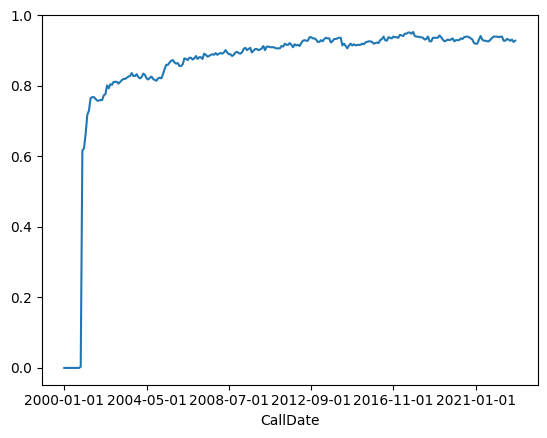

In [112]:
(final_df.notna().sum(axis=1)/600).plot()

In [123]:
final_df = final_df.dropna(axis=0,how='all').dropna(axis=1,how='all')

In [124]:
ranked_df = final_df.T
###### HAY QUE HACER DE FORMA VECTORIZADA #########
for date,prices in zip(final_df.index,final_df.astype(float).values):
    ranked_df[date] = pd.qcut(prices,10,duplicates='drop',labels=False)
ranked_df
#### decil 0 tiene los valores mas bajos y el 9 los mas altos ####
def deciles_lists(df):
    diccionario = {}
    for i in range(10):
        diccionario[f'decil_{i}'] = {}
        for date,ranks in df.items():
            diccionario[f'decil_{i}'][date] = ranks.loc[ranks == i].index.tolist()
    return diccionario
deciles_dict = deciles_lists(ranked_df)

In [144]:
ranked_df.iloc[:,1].value_counts()

5.0    37
3.0    37
4.0    37
8.0    37
1.0    37
6.0    37
2.0    37
0.0    37
9.0    37
7.0    37
Name: 2001-02-01, dtype: int64

In [146]:
ranked_df.drop(columns=ranked_df.columns[0],inplace=True)

In [149]:
values = []
for i in ranked_df.items():
    values.append(np.mean(i[1].value_counts()))

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  96,
  97,
  98,
  99,
  100,
  101,
  102,
  103,
  104,
  105,
  106,
  107,
  108,
  109,
  110,
  111,
  112,
  113,
  114,
  115,
  116,
  117,
  118,
  119,
  120,
  121,
  122,
  123,
  124,
  125,
  126,
  127,
  128,
  129,
  130,
  131,
  132,
  133,
  134,
  135,
  136,
  137,
  138,
  139,
  140,
  141,
  142,
  143,
  144,
  145,
  146,
  147,
  148,
  149,
  150,
  151,
  152,
  153,
  154,
  155,
  156,
  157,
  15

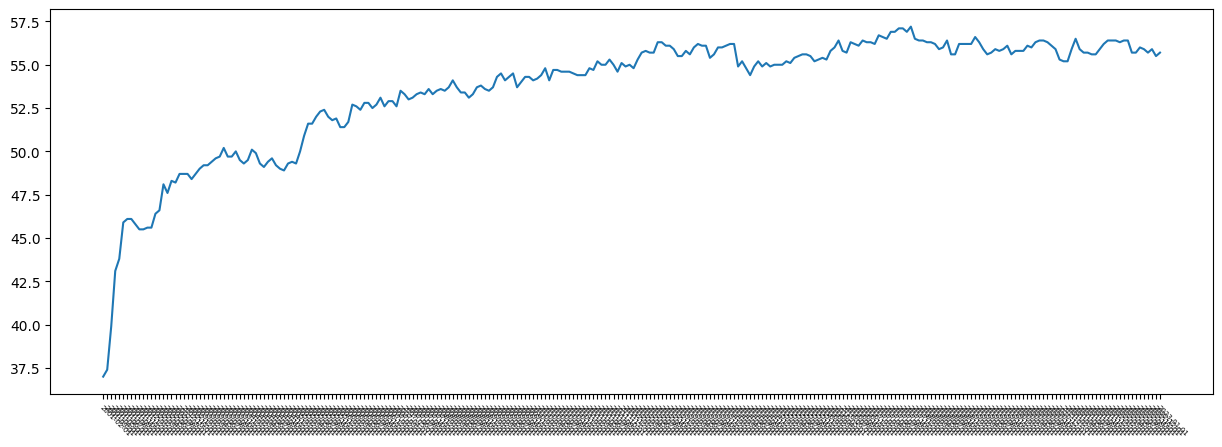

In [161]:
plt.figure(figsize=(15,5))
plt.plot(ranked_df.columns,values)
plt.xticks(rotation=-45,ha='left',rotation_mode='anchor',fontsize=5)

<AxesSubplot: xlabel='CallDate'>

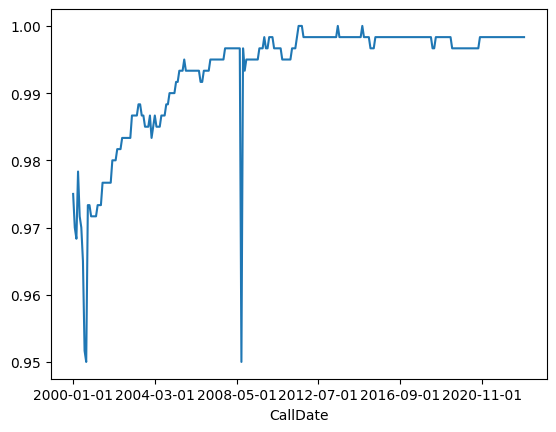

In [162]:
complete_df = pd.read_csv('../data/priceclose_complete.csv',index_col=0)
precios_df=complete_df.pivot(index='CallDate',columns='Instrument',values='Price Close')
(precios_df.T.notna().sum()/600).plot()

In [163]:
deciles_dict = deciles_lists(ranked_df)
rentabilidad_acciones_df = precios_df.pct_change()
rentabilidad_acciones_df

Instrument,1COV.DE,1U1.DE,A2.MI,A3M.MC,AAAA.L^C21,AAH.AS^D08,AAK.ST,AAL.L,AALB.AS,AB.L^G07,...,YAR.OL,YIT.HE,YSO.LS,ZALG.DE,ZEL.MC^K15,ZIGGO.AS^L14,ZO1G.DE^A22,ZODC.PA^C18,ZOT.MC^E22,ZURN.S
CallDate,,,,,,,,,,,,,,,,,,,,,
2000-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-02-01,NaN,NaN,0.105276,NaN,NaN,-0.143145,NaN,NaN,NaN,-0.124825,...,NaN,NaN,0.012214,NaN,NaN,NaN,NaN,NaN,NaN,-0.153537
2000-03-01,NaN,NaN,0.445866,NaN,NaN,0.020706,NaN,NaN,NaN,-0.039521,...,NaN,NaN,0.219457,NaN,NaN,NaN,NaN,NaN,NaN,-0.068273
2000-04-01,NaN,NaN,-0.138705,NaN,NaN,0.073767,NaN,NaN,NaN,0.103091,...,NaN,NaN,-0.195269,NaN,NaN,NaN,NaN,NaN,NaN,0.181457
2000-05-01,NaN,NaN,-0.129494,NaN,NaN,-0.036496,NaN,-0.052128,NaN,-0.054192,...,NaN,NaN,-0.150817,NaN,NaN,NaN,NaN,NaN,NaN,-0.111035
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-01,-0.104992,0.0,-0.091285,0.0,0.0,0.000000,-0.127370,-0.080638,-0.134493,0.000000,...,0.009358,0.0,0.000000,-0.182728,0.0,0.0,0.0,0.0,0.0,0.014964
2022-10-01,-0.001352,0.0,-0.091091,0.0,0.0,0.000000,-0.083538,0.002274,-0.044155,0.000000,...,-0.136254,0.0,0.000000,-0.082540,0.0,0.0,0.0,0.0,0.0,-0.056986
2022-11-01,0.148612,0.0,0.123225,0.0,0.0,0.000000,0.077370,0.032707,0.059224,0.000000,...,0.257820,0.0,0.000000,0.201186,0.0,0.0,0.0,0.0,0.0,0.054390


In [165]:
rentabilidades_dict = {}
rentabilidades_dict['equiponderado'] = {}
for decil,fechas in deciles_dict.items():
    rentabilidades_dict[decil] = {}
    for fecha, stocks in fechas.items():
        rentabilidades_dict[decil][fecha] = rentabilidad_acciones_df.loc[fecha,stocks].mean()
        rentabilidades_dict['equiponderado'][fecha] = rentabilidad_acciones_df.loc[fecha].mean()

In [185]:
rentabilidades_dict

{'equiponderado': {'2001-02-01': 0.021671358844567886,
  '2001-03-01': -0.04075430322146008,
  '2001-04-01': -0.0401873795584454,
  '2001-05-01': 0.041330560588565136,
  '2001-06-01': 0.012691886078481254,
  '2001-07-01': -0.03188478970457344,
  '2001-08-01': -0.02842106927954825,
  '2001-09-01': -0.04189636581395606,
  '2001-10-01': -0.11923657635132978,
  '2001-11-01': 0.06922151159774816,
  '2001-12-01': 0.05150384070292393,
  '2002-01-01': 0.021358519989343613,
  '2002-02-01': -0.0012289500566871607,
  '2002-03-01': -0.0005976110080808449,
  '2002-04-01': 0.03358689228928647,
  '2002-05-01': -0.022293640276378448,
  '2002-06-01': -0.02713481032788829,
  '2002-07-01': -0.06510626435255919,
  '2002-08-01': -0.09820444569242433,
  '2002-09-01': 0.015125626525806615,
  '2002-10-01': -0.1033145221257514,
  '2002-11-01': 0.05679428835971323,
  '2002-12-01': 0.0499450909961024,
  '2003-01-01': -0.05803808435767955,
  '2003-02-01': -0.038774215742881896,
  '2003-03-01': -0.0362477458713632

Text(0.5, 1.0, 'NAV Absoluto')

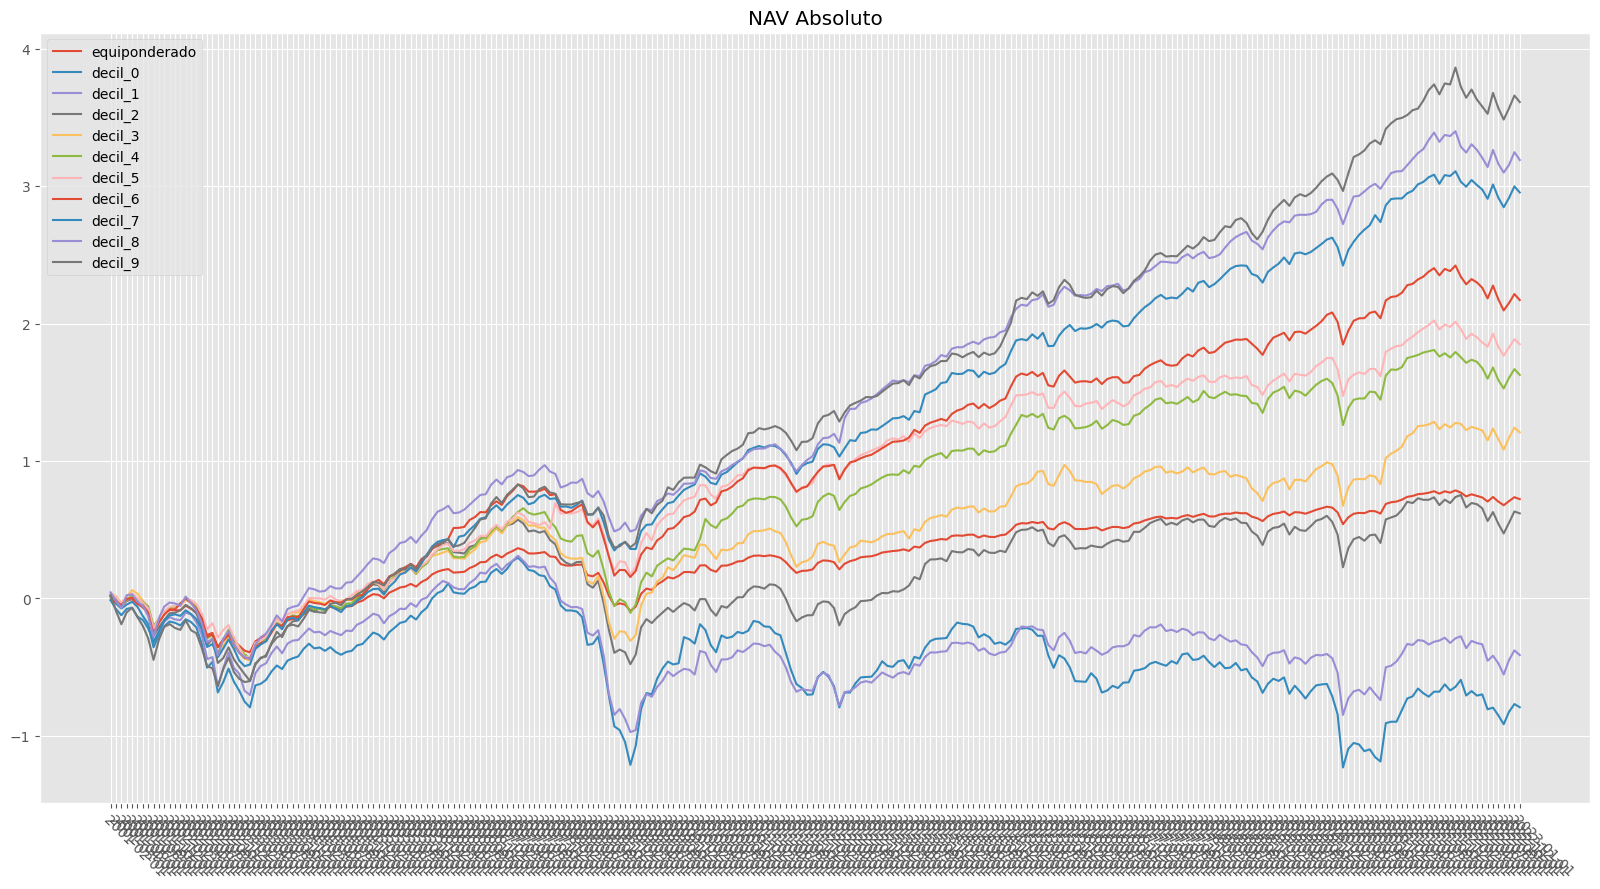

In [191]:
plt.style.use('ggplot')
plt.figure(figsize=(20,10))
for decil in rentabilidades_dict:
    plt.plot(list(rentabilidades_dict['decil_0'].keys()),np.array(list(rentabilidades_dict[decil].values())).cumsum(),label=decil)
plt.xticks(rotation=-45,fontsize=10,ha='left',rotation_mode='anchor')
plt.legend()
plt.title('NAV Absoluto')

Text(0.5, 1.0, 'NAV relativo a Equiponderado')

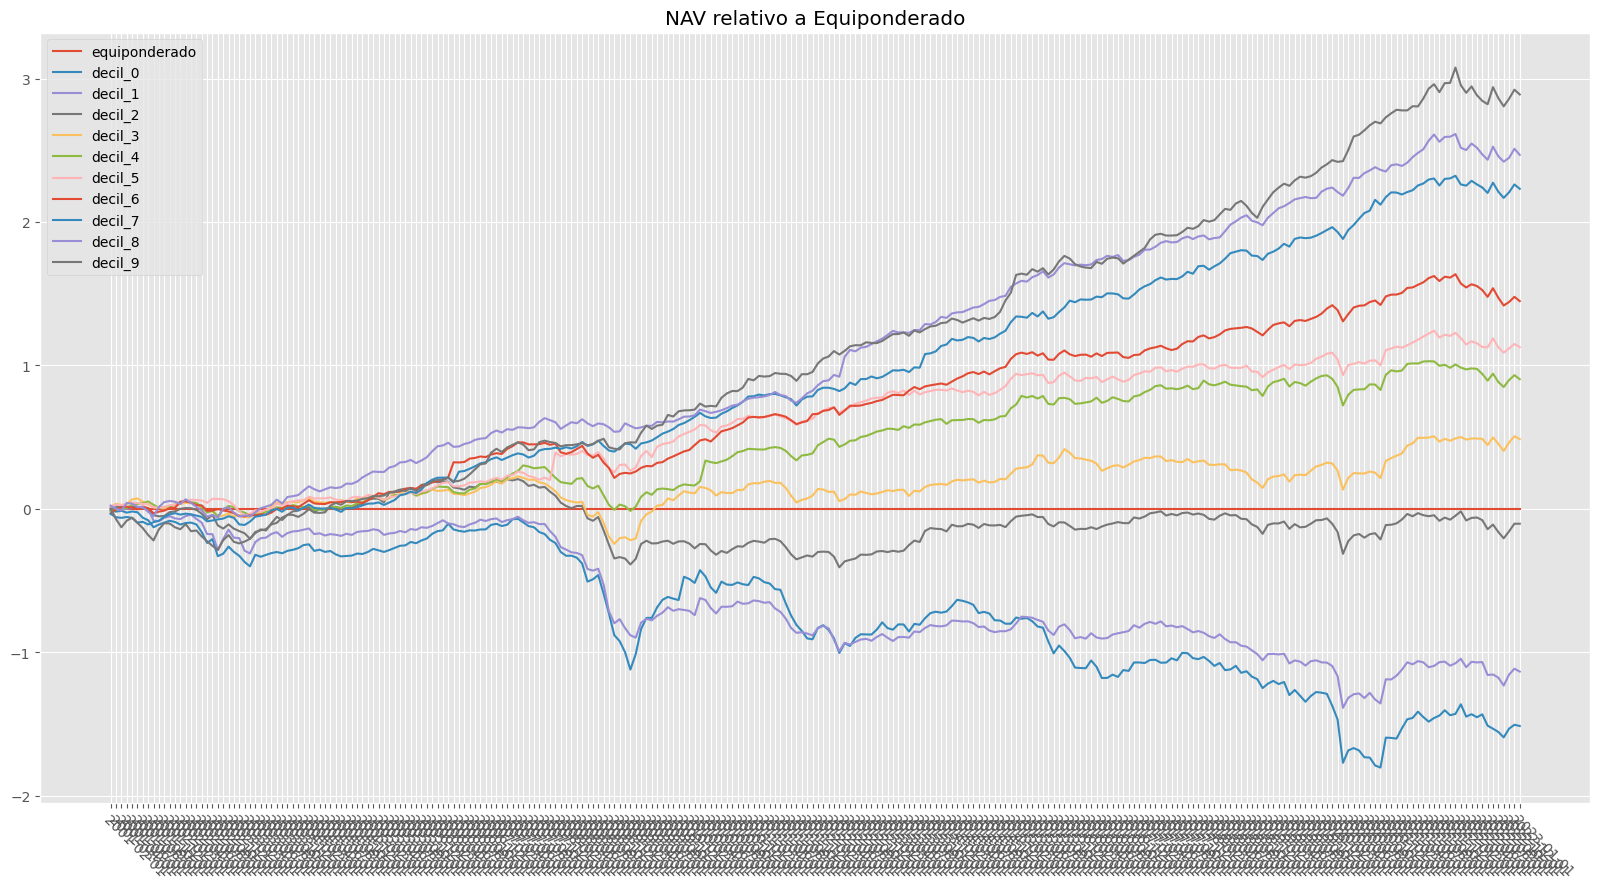

In [190]:
equiponderado = np.array(list(rentabilidades_dict['equiponderado'].values()))
plt.figure(figsize=(20,10))
for decil in rentabilidades_dict:
    plt.plot(list(rentabilidades_dict['decil_0'].keys()),(np.array(list(rentabilidades_dict[decil].values()))-equiponderado).cumsum(),label=decil)
plt.xticks(rotation=-45,fontsize=10,ha='left',rotation_mode='anchor')
plt.legend()
plt.title('NAV relativo a Equiponderado')

Text(0.5, 1.0, 'Rentabilidad media anualizada')

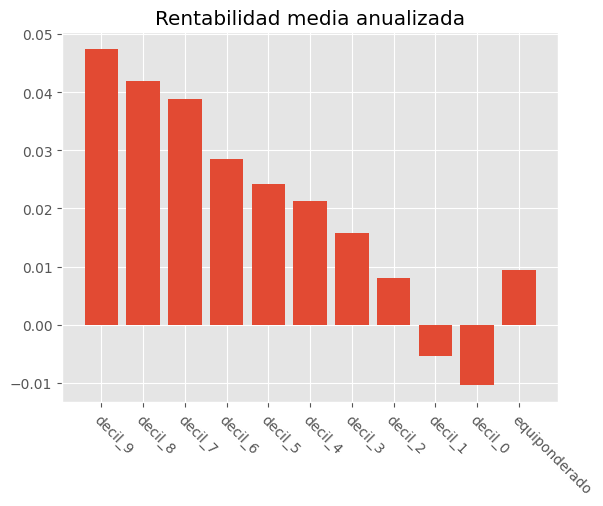

In [192]:
keys = list(rentabilidades_dict.keys())
rentabilidades_medias = [np.mean(list(rentabilidades_dict[decil].values()))*np.sqrt(12) for decil in rentabilidades_dict]

plt.bar(keys[::-1],rentabilidades_medias[::-1])
plt.xticks(rotation=-45,ha='left',rotation_mode='anchor')
plt.title('Rentabilidad media anualizada')

Text(0.5, 1.0, 'Volatilidad Anualizada')

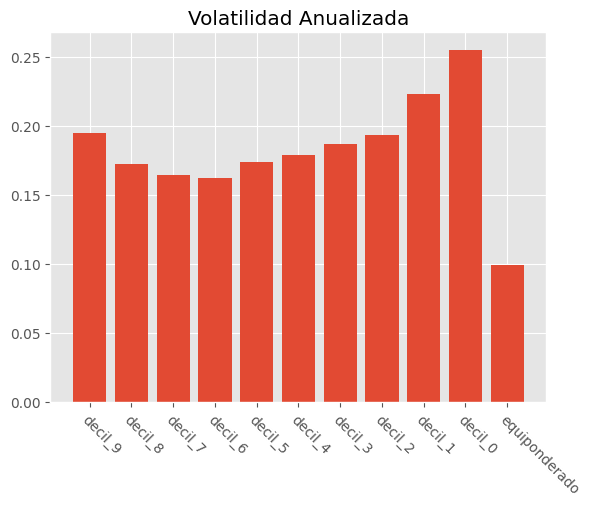

In [193]:
volatilidades_anualizadas = [np.std(list(rentabilidades_dict[decil].values()))*np.sqrt(12) for decil in rentabilidades_dict]

plt.bar(keys[::-1],volatilidades_anualizadas[::-1])
plt.xticks(rotation=-45,ha='left',rotation_mode='anchor')
plt.title('Volatilidad Anualizada')

Text(0.5, 1.0, 'Ratio Sharpe')

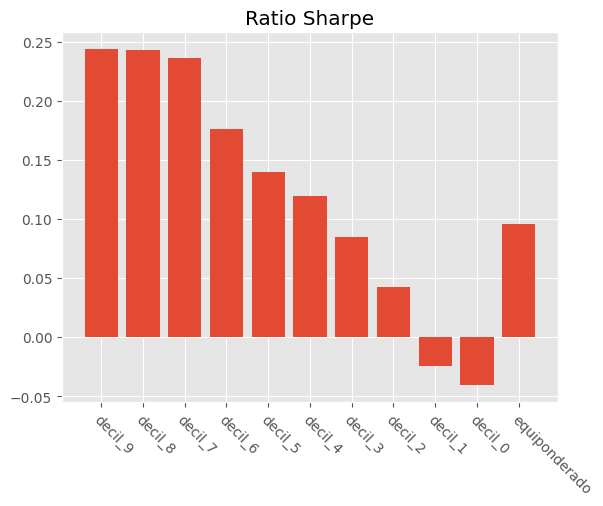

In [195]:
sharpe = np.array(rentabilidades_medias)/np.array(volatilidades_anualizadas)

plt.bar(keys[::-1],sharpe[::-1])
plt.xticks(rotation=-45,ha='left',rotation_mode='anchor')
plt.title('Ratio Sharpe')